## Comparing between gradient boosting and InfiniteBoost for regression task

Experiments are run on the [UCI YearPredictionMSD](https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD). 75% randomly chosen data are used for training and remain part - for test.

In [1]:
DATASETS_FOLDER = '../../datasets/'
N_THREADS = 4

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from collections import OrderedDict
import numpy
import joblib
import pandas

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from infiniteboost import ResearchGradientBoostingBase, InfiniteBoostingWithHoldout, BinTransformer
from infiniteboost.researchlosses import MSELoss

Prepare data for training and test

In [3]:
common_trainX = pandas.read_hdf(DATASETS_FOLDER + 'YearPredictionMSD.hdf', key='data')
common_trainY = pandas.read_hdf(DATASETS_FOLDER + 'YearPredictionMSD.hdf', key='target')

In [4]:
trainX, testX, trainY, testY = train_test_split(common_trainX, common_trainY, train_size=0.75, random_state=42)
del common_trainX

Transform features to small integers (binarization)

In [5]:
transformer = BinTransformer().fit(trainX)
bin_trainX = transformer.transform(trainX)
bin_testX  = transformer.transform(testX)
del trainX, testX

## Training of gradient boosting and InfiniteBoost for the same boosting settings

In [6]:
# define randomly chosen parameters
params = dict(loss=MSELoss(),
              max_depth=7, max_features=0.7, subsample=0.7, 
              n_estimators=10000,
              random_state=42, 
              n_threads=N_THREADS)

In [7]:
clfs = OrderedDict()

Train InfiniteBoost with capacities automatically adapted during training on a holdout (5% of the training data are taken as a holdout)

In [8]:
%%time
hinfi_clf = InfiniteBoostingWithHoldout(**params)
hinfi_clf.fit(bin_trainX, trainY)
clfs['inf'] = hinfi_clf

CPU times: user 2h 8min 43s, sys: 2min 50s, total: 2h 11min 34s
Wall time: 1h 12min 50s


Train gradient boosting with different learning rates

In [9]:
for learning_rate in [0.02, 0.05, 0.1, 0.2]:
    usual_clf = ResearchGradientBoostingBase(learning_rate=learning_rate, **params)
    %time usual_clf.fit(bin_trainX, trainY)
    clfs[learning_rate] = usual_clf
    joblib.dump(clfs, 'models/mse_songs.pkl', protocol=2)

CPU times: user 2h 6min 6s, sys: 2min 18s, total: 2h 8min 24s
Wall time: 1h 11min 10s
CPU times: user 2h 5min 18s, sys: 17.1 s, total: 2h 5min 36s
Wall time: 1h 9min 8s
CPU times: user 2h 5min 26s, sys: 16.4 s, total: 2h 5min 42s
Wall time: 1h 6min 40s
CPU times: user 2h 5min 23s, sys: 15.8 s, total: 2h 5min 39s
Wall time: 1h 7min 36s


## Plotting

In [10]:
def compute_qualities(X, y, step=10):
    Qualities = OrderedDict()
    for name, clf in clfs.items():
        stops = []
        quals = []
        for i, p in enumerate(clf.staged_decision_function(X)):
            if (i + 1) % step == 0:
                stops.append(i)
                quals.append(mean_squared_error(y, p))
        Qualities[name] = [stops, quals]
    return Qualities

In [11]:
Qualities = compute_qualities(bin_testX, testY)
joblib.dump(Qualities, './plots/mse_songs_qualities.pkl', protocol=2)

['./plots/mse_songs_qualities.pkl']

In [12]:
Qualities = joblib.load('./plots/mse_songs_qualities.pkl')

Comparison of InfiniteBoost and gradient boosting with different learning rates

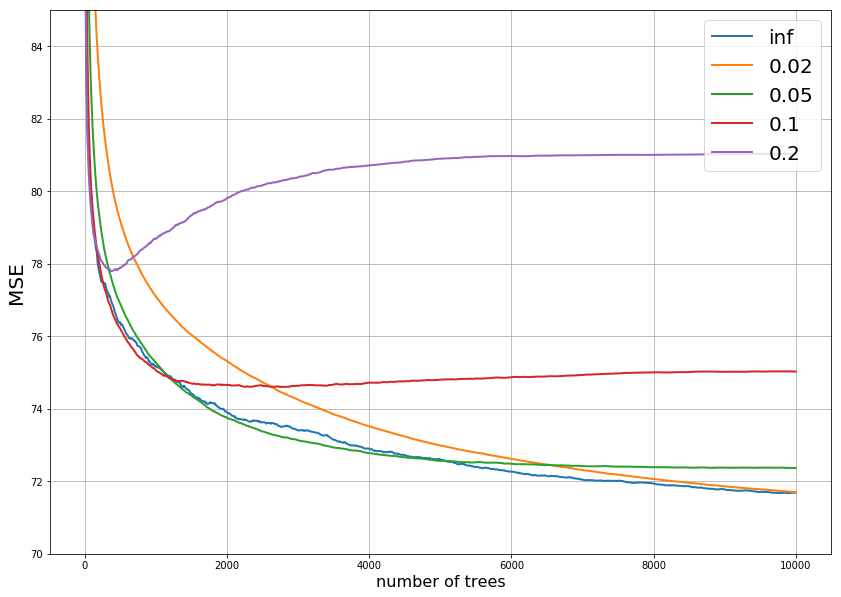

In [13]:
plt.figure(figsize=[14, 10])
for name, (stops, quals) in Qualities.items():
    plt.plot(stops, quals, label=name, linewidth=2)

plt.grid()
plt.xlabel('number of trees', fontsize=16)
plt.ylabel('MSE', fontsize=20)
plt.rcParams['xtick.labelsize'] = 16 
plt.rcParams['ytick.labelsize'] = 16 

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['pdf.use14corefonts'] = True

plt.legend(loc='upper right', fontsize=20)
plt.ylim(70, 85)

plt.savefig('./plots/songs_mse.pdf', bbox_inches='tight')
plt.show()

Plot capacities adaptation dependent on iterations

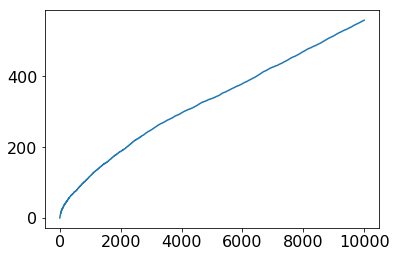

In [14]:
plt.plot(hinfi_clf.capacities)